In [169]:
import IPython.core.display
import matplotlib
import operator

def apply_styles():
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['figure.figsize'] = (18, 6)
    matplotlib.rcParams['lines.linewidth'] = 1
apply_styles()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import scale, PolynomialFeatures
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report, precision_score

from sklearn.model_selection import train_test_split


# Data Exploration

In [170]:
#Load data
df = pd.read_csv("../Data/radar2.csv", header=None,  names=['time','x','y','z'])#,index_col=0)
# df.head(5)
print("Shape:",df.shape)
print("Describe:")
df.describe()

Shape: (120, 4)
Describe:


,time,x,y,z
count,120.000000,120.000000,120.000000,120.000000
mean,595.000000,3225.819812,3021.805906,11339.534653
std,347.850543,1748.638182,1637.809143,3720.692138
min,0.000000,5.794911,-4.634275,4335.280899
25%,297.500000,1768.841721,1656.044204,8229.057285
50%,595.000000,3341.318281,3134.307707,11673.829937
75%,892.500000,4738.585393,4452.866754,14621.929099
max,1190.000000,5999.654490,5610.820711,16948.732742


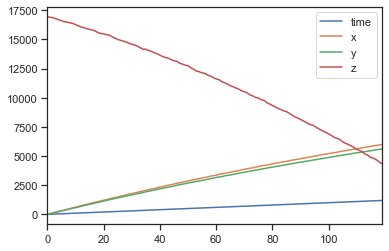

In [171]:
df.plot() #x grows faster than y, z has some random variances

In [172]:
df_buildings = pd.read_csv("../Data/mbuildings.csv")
df_buildings.head(5)
df_buildings.describe() #we can see there are missing residents

,residents,bed,bath,x,y
count,1656.000000,2417.000000,2417.000000,2417.000000,2417.000000
mean,2.175725,2.283409,2.103020,7158.813206,6650.869640
std,1.296489,1.200659,1.233391,69.128844,68.081989
min,0.000000,1.000000,1.000000,7024.160000,6514.160000
25%,1.000000,1.000000,1.000000,7101.760000,6597.360000
50%,2.000000,2.000000,2.000000,7157.280000,6650.000000
75%,3.000000,3.000000,3.000000,7215.360000,6705.360000
max,7.000000,9.000000,9.000000,7295.840000,6785.840000


Q1 (20). Using (any) methods you learned in this (wonderful) class estimate the expected point of impact. The
impact is obviously determined when altitude of the meteorite is 0.

## Ideas
- Predict phisics, aka. velocity, acceleration & direction.
    - Problem? What if there is wind or some other force we dont account for.
- Use different predictors that have biger memory for multiple hidden variables.

-get x & y variance, then predict the one with the least variance, use another model with the predicted variable as input too to predict the other coordinate

Polynomial regression

   

## Q1 - Predict x and y 

- Split train and test data.
- Base model (Linear Regression)
- Better model (Polynomial Regression)

In [173]:
#Split data
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
    return X_train, X_test, y_train, y_test

In [174]:
def plot_linear_reg(X_test, y_test, y_pred):
    plt.scatter(X_test, y_test,  color='gray')
    plt.plot(X_test, y_pred, color='red', linewidth=2)
    plt.show()
    #Todo: Show in the same figure the scatter plot and bar comparison
    # df_pred =  pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    # print(df_pred.head(25))
    # df_pred.plot(kind='bar',figsize=(10,6))
    # plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    # plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    # plt.show()

In [175]:
def linear_reg_model(X, y):
    X_train, X_test, y_train, y_test = split_data(X,y)

    regr = skl_lm.LinearRegression()
    regr.fit(X_train,y_train)    
    y_pred = regr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print("Regression Coefficient:",regr.coef_)
    print("Regression Intercept:",regr.intercept_)
    print("R^2: {}".format(regr.score(X_test, y_test)))
    print("Root Mean Squared Error: {}".format(rmse))

    plot_linear_reg(X_test, y_test, y_pred)
    return regr

Regression Coefficient: [5.24863186]
Regression Intercept: 158.43975443351474
R^2: -0.0014149076714016218
Root Mean Squared Error: 287.93962053307393


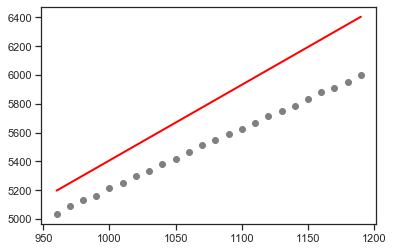

Regression Coefficient: [4.91586334]
Regression Intercept: 148.8646970013292
R^2: -0.009697946176728589
Root Mean Squared Error: 269.8154016267517


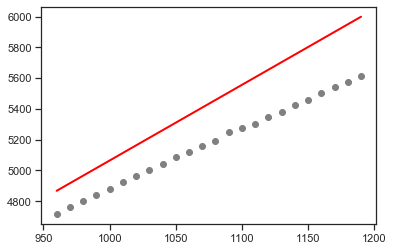

Regression Coefficient: [-0.09940561]
Regression Intercept: 1737.2302198794036
R^2: -0.2746809080567405
Root Mean Squared Error: 78.1527095996798


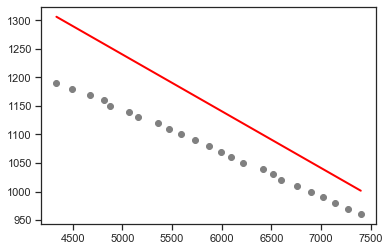

In [176]:
#Todo: Name plot and results. maybe add them all to a figure
model_reg_x = linear_reg_model(df[['time']].as_matrix(),df.x)
model_reg_y = linear_reg_model(df[['time']].as_matrix(),df.y)
model_reg_time = linear_reg_model(df[['z']].as_matrix(),df.time)

In [177]:
def predict_coord(model_reg_x, model_reg_y, model_reg_time, altitude=0):
    coord_x = model_reg_x.predict([[1435.1744727246803]])
    coord_y = model_reg_y.predict([[1435.1744727246803]])
    coord_time = model_reg_time.predict([[altitude]])
    print("Predicted points when altitude equals "+str(altitude)+" are: ", str(coord_time), str(coord_x),str(coord_y))
    # print("X: ")
predict_coord(model_reg_x, model_reg_y, model_reg_time)


Predicted points when altitude equals 0 are:  [1737.23021988] [7691.14221269] [7203.98627013]


### Polynomial approach

In [178]:
def calculate_degree():
    return 3
#Todo: Add code to automatically check which degree of polynomial is best
#Added this later so i can use poly_reg_model when testing 1000 datasets
def poly(X,y):
    X_train, X_test, y_train, y_test = split_data(X,y)
    model=poly_reg_model(X_train, X_test, y_train, y_test)
    return model


def poly_reg_model(X_train, X_test, y_train, y_test):
    poly_degree = calculate_degree()
    polynomial_features= PolynomialFeatures(degree=poly_degree)
    x_poly = polynomial_features.fit_transform(X_train)

    model = skl_lm.LinearRegression()
    model.fit(x_poly, y_train)
    #######################################################
    ###########Train
    #######################################################
    y_poly_pred = model.predict(x_poly)
    rmse = np.sqrt(mean_squared_error(y_train,y_poly_pred))
    r2 = r2_score(y_train,y_poly_pred)
    print("Regression Coefficient:",model.coef_)
    print("Regression Intercept:",model.intercept_)
    print("R^2: {}".format(r2))
    print("Root Mean Squared Error: {}".format(rmse))

    plt.scatter(X_train, y_train, s=10)
    # sort the values of x before line plot
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(X_train,y_poly_pred), key=sort_axis)
    X_train_pol, y_poly_pred = zip(*sorted_zip)
    plt.plot(X_train_pol, y_poly_pred, color='m')
    plt.show()

    #######################################################
    #########Test
    #######################################################    
    x_test_poly = polynomial_features.fit_transform(X_test)
    y_poly_pred = model.predict(x_test_poly)

    rmse = np.sqrt(mean_squared_error(y_test,y_poly_pred))
    r2 = r2_score(y_test,y_poly_pred)
    print("Regression Coefficient:",model.coef_)
    print("Regression Intercept:",model.intercept_)
    print("R^2: {}".format(r2))
    print("Root Mean Squared Error: {}".format(rmse))

    plt.scatter(X_test, y_test, s=10)
    # sort the values of x before line plot
    #https://towardsdatascience.com/polynomial-regression-bbe8b9d97491
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(X_test,y_poly_pred), key=sort_axis)
    X_test_pol, y_poly_pred = zip(*sorted_zip)
    plt.plot(X_test_pol, y_poly_pred, color='m')
    plt.show()
    return model


Regression Coefficient: [ 0.00000000e+00  6.25967439e+00 -1.09500622e-03  3.58411096e-08]
Regression Intercept: 1.5794961222050006
R^2: 0.9999879298718962
Root Mean Squared Error: 5.059279514051066


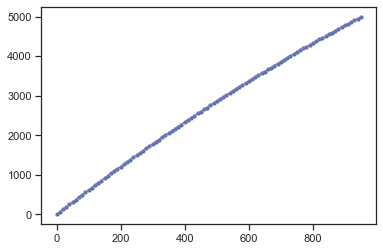

Regression Coefficient: [ 0.00000000e+00  6.25967439e+00 -1.09500622e-03  3.58411096e-08]
Regression Intercept: 1.5794961222050006
R^2: 0.9949616296385481
Root Mean Squared Error: 20.423936244345953


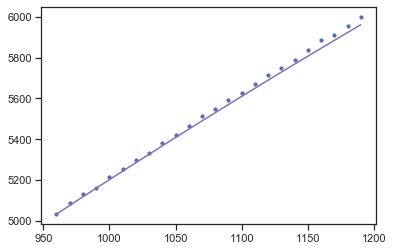

Regression Coefficient: [ 0.00000000e+00  5.95546775e+00 -1.26064974e-03  1.93861752e-07]
Regression Intercept: -5.696363913156347
R^2: 0.9999809042239215
Root Mean Squared Error: 5.9602568645526475


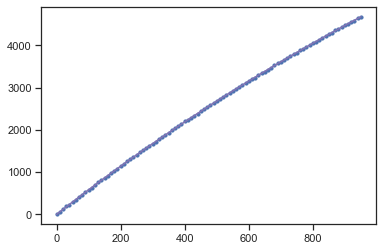

Regression Coefficient: [ 0.00000000e+00  5.95546775e+00 -1.26064974e-03  1.93861752e-07]
Regression Intercept: -5.696363913156347
R^2: 0.9993033138610747
Root Mean Squared Error: 7.087443096422587


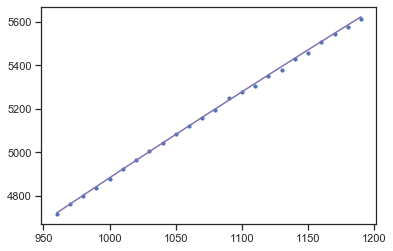

Regression Coefficient: [ 0.00000000e+00 -1.33015420e-01  5.96967533e-06 -2.40551662e-10]
Regression Intercept: 1717.6373092912938
R^2: 0.999875084922009
Root Mean Squared Error: 3.09716596757837


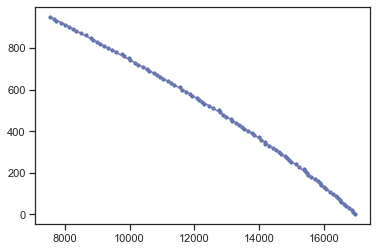

Regression Coefficient: [ 0.00000000e+00 -1.33015420e-01  5.96967533e-06 -2.40551662e-10]
Regression Intercept: 1717.6373092912938
R^2: 0.9104908328251047
Root Mean Squared Error: 20.709854966006883


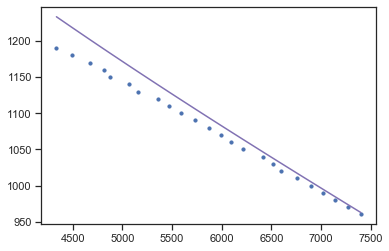

In [179]:
model_reg_x = poly(df[['time']].as_matrix(),df.x)
model_reg_y = poly(df[['time']].as_matrix(),df.y)
model_reg_time = poly(df[['z']].as_matrix(),df.time)

In [180]:
def predict_coord(model_reg_x, model_reg_y, model_reg_time, altitude=0):
    polynomial_features= PolynomialFeatures(degree=calculate_degree())
    x_poly = polynomial_features.fit_transform([[1498.99552787]])
    time_poly = polynomial_features.fit_transform([[0]])   
    coord_x = model_reg_x.predict(x_poly) # 3 times because model was trainded with polynomials of degree 2
    coord_y = model_reg_y.predict(x_poly)
    coord_time = model_reg_time.predict(time_poly)
    print("Predicted points when altitude equals "+str(altitude)+" are: ", str(coord_time), str(coord_x),str(coord_y))
    # print("X: ")
predict_coord(model_reg_x, model_reg_y, model_reg_time)


Predicted points when altitude equals 0 are:  [1717.63730929] [7045.05892879] [6741.82871506]


## Q2 - Resampling

“You create multiple (at least 1000, feel free to go for more) new datasets based on resampling (with
replacement) from the original dataset (note that the original dataset has 130 data points). For each one of these
1000 new datasets, you pick 130 data points (from the 130 original ones) using the following process: You pick
one data point randomly, then you “put it back” (that is the meaning of resampling with replacement) and you
repeat the same process 129 times.

In [181]:
# amount_datasets = 1000
# df_1000 = []
# for i in range(amount_datasets):
#     df_resample = df.sample(n=130,replace=True)
#     df_1000.append(df_resample)

In [182]:
#Split data
#Manually:
###Create a list with numbers from 0 to n (range function?), sample n numbers with replacement, this will be the indexes for train data.
###Get the missing numbers from the previous list, this will be the test data. (? How do we control the amount of test data, what if they are jsut 10)

# ##Approach 2: split randomly data between train and test 
# def split_data_with_resampling(X, y):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)
#     df_resample = df.sample(n=130,replace=True)
#     df_1000.append(df_resample)
#     return X_train, X_test, y_train, y_test


In [183]:
#If i want to set a max of test points then i could first sample the test points with a limit of 30 for example and no repetitions, then for test the reamining oversample to 130
def split_data_with_resampling(X, y, seed=42, n=130):
    np.random.seed(seed)
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)    
    zero_to_n = np.arange(n) #ndarray with numbers from 0 to n (130)
    train_indices = np.random.randint(0, n, size=n) # ndarray with n random numbers from 0 to n with repetions.
    test_indices = np.setdiff1d(zero_to_n,train_indices) # the indices not in train_indeces go to test indices, size vary. 
    # size_test_indices = len(np.unique(test_indices))
    # print(size_test_indices)
    # print(zero_to_n)
    # print(train_indices)
    X_train = X[train_indices]
    X_test  = X[test_indices]
    y_train = y[train_indices]
    y_test  = y[test_indices]
    return X_train, X_test, y_train, y_test

def create_datasets_resampling(x, y, amount_datasets = 10000):
    df_1000 = []
    for seed in range(amount_datasets):
        df_resample = split_data_with_resampling(x,y, seed, n=len(x))
        df_1000.append(df_resample)
    return df_1000


import statistics

#light because just fit and dont plot
def poly_reg_model_light(X_train, X_test, y_train, y_test):
    poly_degree = calculate_degree()
    polynomial_features= PolynomialFeatures(degree=poly_degree)
    x_poly = polynomial_features.fit_transform(X_train)

    model = skl_lm.LinearRegression()
    model.fit(x_poly, y_train)
    x_test_poly = polynomial_features.fit_transform(X_test)
    y_poly_pred = model.predict(x_test_poly)

    rmse = np.sqrt(mean_squared_error(y_test,y_poly_pred))
    r2 = r2_score(y_test,y_poly_pred)
    return model, rmse, r2


import scipy
from scipy.stats import sem, t
# from scipy import mean
def test_confidence(independent_var,column,predict_at=None):
    polynomial_features= PolynomialFeatures(degree=calculate_degree())
    x_poly = polynomial_features.fit_transform([[predict_at]])
    datasets_x = create_datasets_resampling(df[[independent_var]].as_matrix(),df[column])
    models = [poly_reg_model_light(*splitted_data) for splitted_data in datasets_x] 
    predictions = [model[0].predict(x_poly) for model in models]
    
    std_err = sem(predictions) 
    mean = scipy.mean(predictions)
    n = len(predictions)
    # ci = scipy.stats.norm.interval(0.95, loc=mean, scale=sigma)
    confidence = 0.90
    h = std_err * t.ppf((1 + confidence) / 2, 3)
    print("std:",std_err)
    print("h", h)
    start = mean - h
    print (start)
    end = mean + h
    print (end)
    print(len(predictions))
    print("Prediction of column ",column," when z = 0 is:",mean)
    rmse_mean = [np.mean(model[1]) for model in models]
    r2_mean = [np.mean(model[2]) for model in models]
    print("rmse mean",np.mean(rmse_mean))
    print("r2 mean",np.mean(r2_mean))
    return mean

# model_reg_x = poly_reg_model(df[['z']].as_matrix(),df.x)
# model_reg_y = poly_reg_model(df[['z']].as_matrix(),df.y)
# model_reg_time = poly_reg_model(df[['z']].as_matrix(),df.time)

In [184]:
time_zero = test_confidence('z','time',predict_at=0)
print("time when altitude is 0:",time_zero)
test_confidence('time','x',predict_at=time_zero)
test_confidence('time','y',predict_at=time_zero)

std: [0.10403459]
h [0.2448312]
[1561.90001556]
[1562.38967796]
10000
Prediction of column  time  when z = 0 is: 1562.144846760953
rmse mean 3.5366200452114134
r2 mean 0.9998923820841812
time when altitude is 0: 1562.144846760953
std: [0.11863239]
h [0.27918513]
[7371.22861436]
[7371.78698463]
10000
Prediction of column  x  when z = 0 is: 7371.507799495527
rmse mean 5.535063528124778
r2 mean 0.999989531610484
std: [0.12228775]
h [0.28778753]
[6925.77811539]
[6926.35369045]
10000
Prediction of column  y  when z = 0 is: 6926.0659029176895
rmse mean 6.113280442234462
r2 mean 0.999985489885078


6926.0659029176895

## Things that didnt work

- Use z to predict x & y
- Polynomial of 2nd degree or higher than 3rd



## Q3


In [185]:
df_buildings = pd.read_csv("../Data/mbuildings.csv")
df_buildings.describe() #we can see there are missing residents

,residents,bed,bath,x,y
count,1656.000000,2417.000000,2417.000000,2417.000000,2417.000000
mean,2.175725,2.283409,2.103020,7158.813206,6650.869640
std,1.296489,1.200659,1.233391,69.128844,68.081989
min,0.000000,1.000000,1.000000,7024.160000,6514.160000
25%,1.000000,1.000000,1.000000,7101.760000,6597.360000
50%,2.000000,2.000000,2.000000,7157.280000,6650.000000
75%,3.000000,3.000000,3.000000,7215.360000,6705.360000
max,7.000000,9.000000,9.000000,7295.840000,6785.840000


# TODO: Use the time interval to get a bigger impact area. 
- Use min time and max time from interval to predict x and y intervals, keep smallest and biggest x,y. 

In [186]:
#df_buildings[df_buildings.residents.isna()]

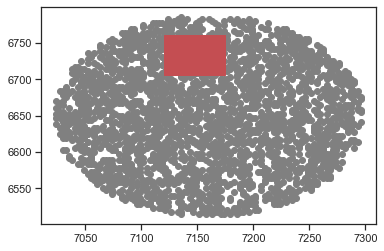

In [187]:
# df_buildings
# def plot_buildings(X_test, y_test, y_pred):
#     # X_test
#     plt.scatter(df_buildings.x, df_buildings.y,  color='gray')
#     # plt.plot(X_test, y_pred, color='red', linewidth=2)
#     plt.show()

fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
ax.scatter(df_buildings.x, df_buildings.y,  color='gray')
# plt.circle([(6647.69176458,6649.26095709-6647.69176458)],(6215.32090271,6217.03291844-6215.32090271))
circle1 = plt.Rectangle(( 7120,6706.04016335),55,55,color='r')
# print(circle1.get_center())
    # plt.plot(X_test, y_pred, color='red', linewidth=2)

# (or if you have an existing figure)
ax.add_patch(circle1)
fig.show()
# [7341.32817503] [6878.25683735]
# ax.add_artist(circle2)
# ax.add_artist(circle3)
# fig.savefig('plotcircles2.png')

In [195]:
def get_buildings_in_range(x_range,y_range,buildings):
    rows_list = []
    for index, row in buildings.iterrows():
        if row.x >= x_range[0] and row.x <= x_range[1] and row.y >= y_range[0] and row.y <= y_range[1]:
            rows_list.append(row)
    return rows_list
# get_buildings_in_range([7116.72073998,7126.88031247],[6701.86802177,6711.85120464],df_buildings)

In [189]:
df_buildings.dtypes

residents    float64
bed            int64
bath           int64
x            float64
y            float64
dtype: object

In [190]:
# Predict missing tenants
#https://www.datacamp.com/community/tutorials/xgboost-in-python
# import xgboost as xgb
df_not_nan =df_buildings[df_buildings.residents.isna()== False]
X = df_not_nan.drop(['residents','x','y'],axis=1)
y = df_not_nan.residents
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 42)
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print(f'Model Accuracy: {tree.score(X_test, y_test)}')

Model Accuracy: 0.4427710843373494


In [191]:
from sklearn import svm
from sklearn import metrics
#Create a svm Classifier
clf = svm.SVC(kernel='rbf',random_state = 42) # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.44879518072289154


In [192]:
lr = skl_lm.LogisticRegression()
lr.fit(X_train, y_train)
print ("Logistic regression Train Accuracy :: ", metrics.accuracy_score(y_train, lr.predict(X_train)))
print ("Logistic regression Test Accuracy :: ", metrics.accuracy_score(y_test, lr.predict(X_test)))

Logistic regression Train Accuracy ::  0.45996978851963743
Logistic regression Test Accuracy ::  0.4608433734939759


In [193]:
mean_residents = np.mean(df_buildings[df_buildings.residents.isna()== False].residents)
df_buildings =df_buildings.fillna(int(mean_residents)) #Since classifiers score are bad we will use the mean
df_buildings[df_buildings.residents.isna()] #sanity check

,residents,bed,bath,x,y


In [199]:
affected_buildings = get_buildings_in_range([7116.72073998,7126.88031247],[6701.86802177,6711.85120464],df_buildings)
affected_residents = sum([building.residents for building in affected_buildings])
print("Affected buildings due to the meteorite: ",affected_buildings)
print("Affected residents due to the meteorite: ",affected_residents)

Affected residents due to the meteorite:  7.0


# Q4 - 